In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix

from toolbox import remove_df_outliers_iqr, split_data, compute_correlation_matrix, remove_correlated_columns, min_max_scale

In [5]:
# load data
df = pd.read_csv("weatherHistory.csv")

# clean data
df = remove_df_outliers_iqr(df)
X, y = split_data(df)

# replace bearing angle with x, y vector components
column = "Wind Bearing (degrees)"
x_component = np.cos(X[column])
y_component = np.sin(X[column])

# build the final dataset (X, y) for training and testing
X["Wind Bearing (Ox)"] = x_component
X["Wind Bearing (Oy)"] = y_component
X = X.drop(["Wind Bearing (degrees)"], axis=1)

# remove correlated features
corr_matrix = compute_correlation_matrix(X)
X = remove_correlated_columns(corr_matrix, X)

# encode target variable
y[y == "rain"] = 0
y[y == "snow"] = 1
y = pd.to_numeric(y)

# scale features using a min-max scaler
for column in X.columns:
    X[column] = min_max_scale(X[column])
X.head()

/Users/luchicla/Work/RAU/rau-software-packs-for-statics-G603CSE-2022-2023/toolbox.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df[column] < lower_limit] = None
/Users/luchicla/Work/RAU/rau-software-packs-for-statics-G603CSE-2022-2023/toolbox.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df[column] > upper_limit] = None


,Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars),Wind Bearing (Ox),Wind Bearing (Oy)
0,0.464354,0.867470,0.530872,0.983,0.459139,0.973439,0.339215
1,0.462237,0.831325,0.536320,0.983,0.472943,0.590200,0.991840
2,0.462640,0.867470,0.147700,0.929,0.481502,0.010320,0.601085
3,0.442876,0.795181,0.530266,0.983,0.494478,0.691863,0.038274
4,0.451346,0.795181,0.415254,0.983,0.497239,0.590200,0.991840


In [6]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Precip Type, dtype: int64

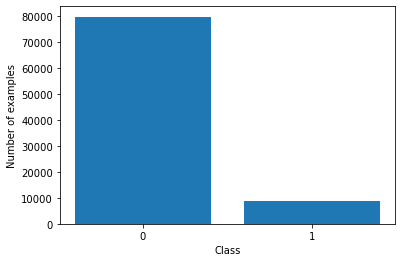

In [9]:
n_examples_class_0 = len(y[y==0])
n_examples_class_1 = len(y[y==1])

_ = plt.figure()
plt.bar([0, 1], [n_examples_class_0, n_examples_class_1])
plt.xticks([0, 1])
plt.ylabel("Number of examples")
plt.xlabel("Class")
plt.show()

In [33]:
# 1. resample the data (pick a subset from the collected data)
# 1.1. under-sample the large class (pick a smaller subset from the collected data)
# 1.2. over-sample the small class  (create more examples with the same / similar statistical properties) [synthetic generation]

# Under-sampling WITHOUT replacement
X = np.array(X)
y = np.array(y)

# determine the number of samples to pick from the larger class
n_examples = n_examples_class_1

# random selection of example indices from the larger class
indices = []
for sample_idx in range(len(y)):
    if y[sample_idx] == 0:
        indices.append(sample_idx)
random_sample_without_replacement = np.random.choice(indices, size=n_examples, replace=False)
random_sample_without_replacement = list(random_sample_without_replacement)

# extract example indices for the other class
class_1_indices = np.where(y == 1)
class_1_indices = list(class_1_indices[0])

# merge the final indices
random_sample = list(random_sample_without_replacement)
random_sample.extend(class_1_indices)

# resample X, y
X_resampled = []
y_resampled = []
for sample_idx in random_sample:
    X_resampled.append(X[sample_idx])
    y_resampled.append(y[sample_idx])

X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)

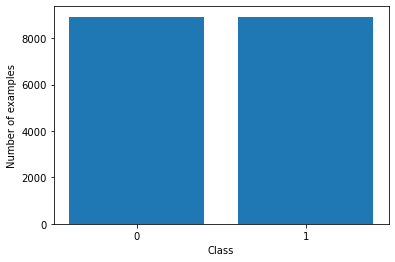

In [35]:
n_examples_class_0_resampled = len(y_resampled[y_resampled==0])
n_examples_class_1_resampled = len(y_resampled[y_resampled==1])

_ = plt.figure()
plt.bar([0, 1], [n_examples_class_0_resampled, n_examples_class_1_resampled])
plt.xticks([0, 1])
plt.ylabel("Number of examples")
plt.xlabel("Class")
plt.show()

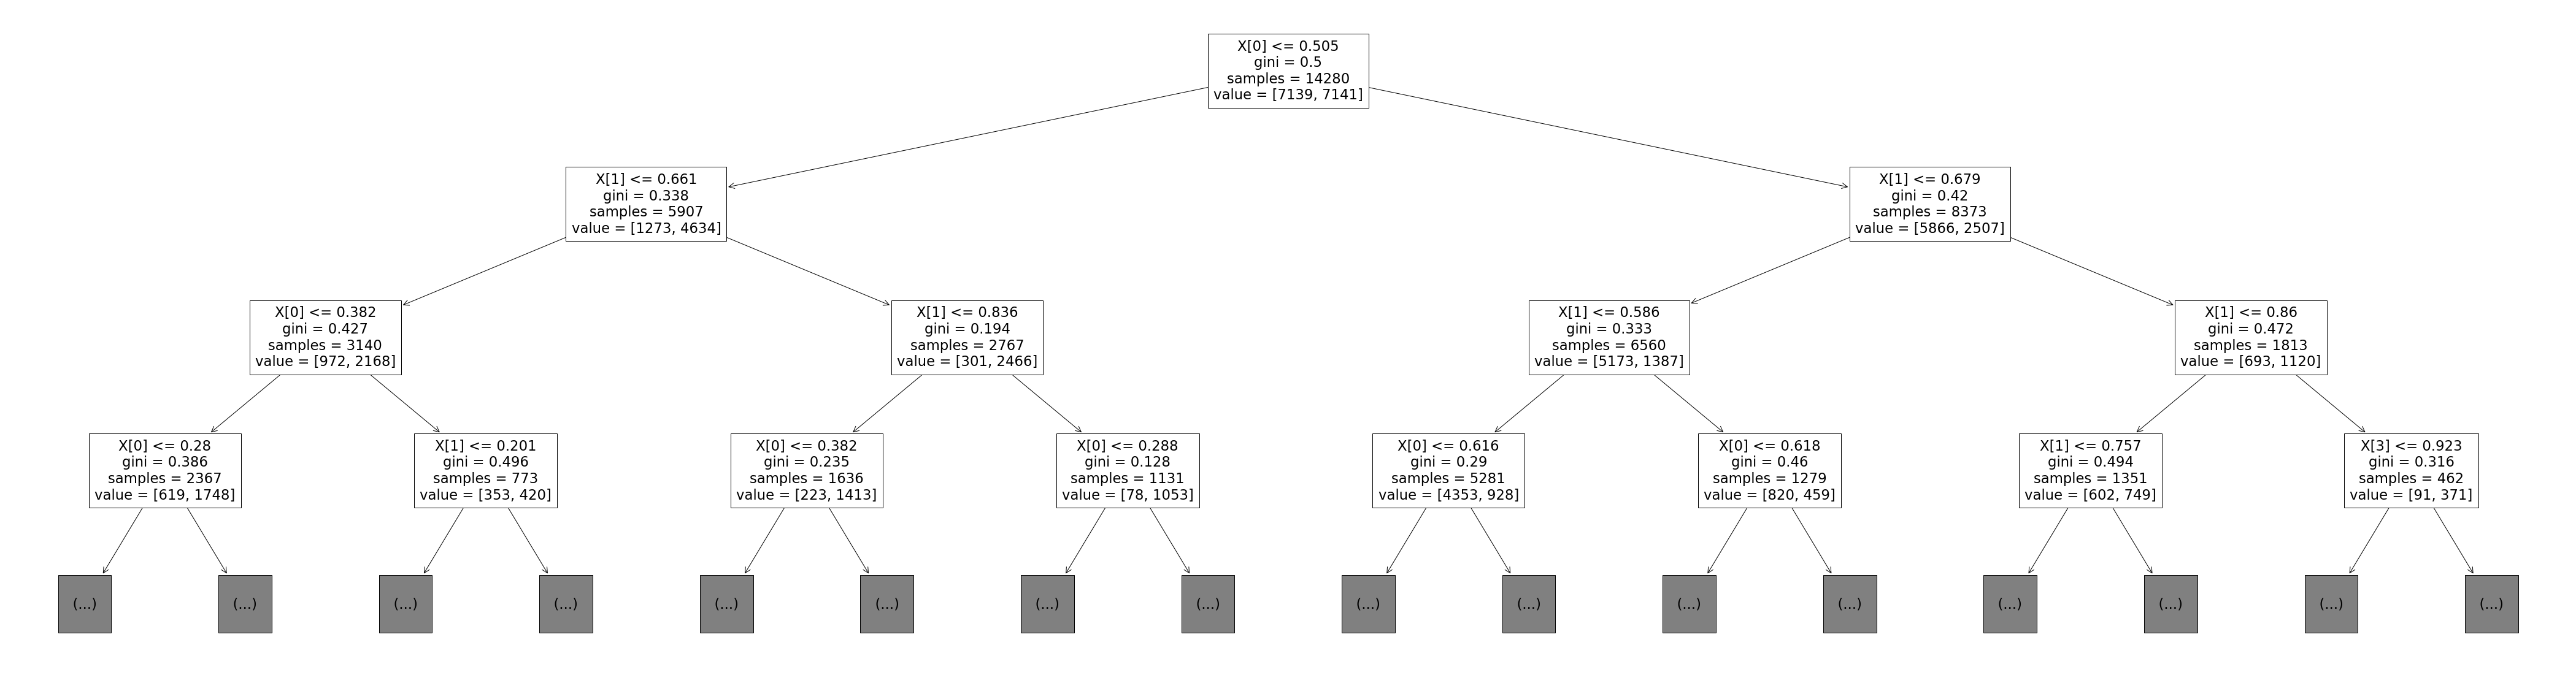

In [49]:
# remove Temperature (C)
X_resampled = X_resampled[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf = clf.fit(X_train, y_train)
fig = plt.figure(figsize=(75, 20))
plot_tree(clf, ax=fig.gca(), max_depth=3)
plt.show()

In [50]:
y_train_predicted = clf.predict(X_train)
y_test_predicted = clf.predict(X_test)

train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_predicted)
test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_predicted)

print(f"Training set accuracy = {train_accuracy * 100}%. Test set accuracy = {test_accuracy * 100}%")

Training set accuracy = 81.87675070028011%. Test set accuracy = 75.23809523809524%


In [68]:
from sklearn.model_selection import GridSearchCV

def scorer(estimator, X_test, y_test):
    y_predict = estimator.predict(X_test)
    return f1_score(y_true=y_test, y_pred=y_predict)

decision_tree = DecisionTreeClassifier()
params = {
    "max_depth": [3, 4, 5, 10, 20, 50],
    "min_samples_split": [1, 2, 3, 4, 5, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5, 10]
}
model = GridSearchCV(decision_tree, params, scoring=scorer)
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split must be an integer greater than 1 or a float in

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 4, 5, 10, 20, 50],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                         'min_samples_split': [1, 2, 3, 4, 5, 10]},
             scoring=<function scorer at 0x7fe7560f6f70>)

In [69]:
model.best_estimator_

DecisionTreeClassifier(max_depth=4)

In [70]:
model.best_score_

0.7745674134417617

In [71]:
model.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [ ]:
# TODO: Train a decision tree classifier using a balanced set produced with random.choice() with replacement

In [ ]:
# TODO: Optimize the parameters of the latest decision tree classifier using GridSearchCV and report on the model performance

In [ ]:
# TODO: Take a look at SMOTE (a method for oversampling the data) [ https://arxiv.org/pdf/1106.1813.pdf ]
# You can try to use SMOTE from this package: [ https://github.com/scikit-learn-contrib/imbalanced-learn ]

In [81]:
class_weights = {
    0: 0.1,
    1: 0.9
}
model_with_class_weights = DecisionTreeClassifier(max_depth=5, class_weight=class_weights, random_state=42)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_with_class_weights.fit(X_train, y_train)

y_train_predicted = model_with_class_weights.predict(X_train)
y_test_predicted = model_with_class_weights.predict(X_test)

train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_predicted)
test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_predicted)

print(f"Training set accuracy = {train_accuracy * 100}%. Test set accuracy = {test_accuracy * 100}%")

Training set accuracy = 77.93321299638988%. Test set accuracy = 77.53962434429465%


In [83]:
confusion_matrix(y_true=y_train, y_pred=y_train_predicted)

array([[49759, 13984],
       [ 1664,  5505]])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


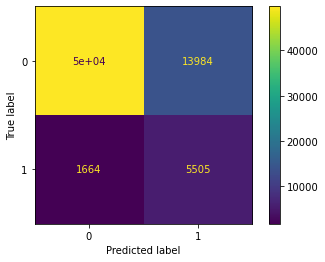

In [84]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_with_class_weights, X_train, y_train)
plt.show()

In [86]:
# Definitions:
# True positive (TP): Real = positive, Predicted = positive
# True negative (TN): Real = negative, Predicted = negative
# False negative (FN): Real = positive, Predicted = negative (type II error, underestimation, misses many cases)
# False positive (FP): Real = negative, Predicted = positive (type I error, overestimation, false alarms)

# Precision = how many items are relevant
# P = TP / (TP + FP)

# Recall = how many relevant items we predict correctly
# R = TP / (TP + FN)

# F1-score
# F1 = 2 * TP / (2 * TP + FP + FN) = 2 * P * R / (P + R)

In [88]:
cm_training = confusion_matrix(y_true=y_train, y_pred=y_train_predicted)
precision_training = precision_score(y_true=y_train, y_pred=y_train_predicted)
f1_training = f1_score(y_true=y_train, y_pred=y_train_predicted)
precision_training, f1_training, cm_training

(0.2824670326851044,
 0.4130092279990997,
 array([[49759, 13984],
        [ 1664,  5505]]))

In [89]:
cm_test = confusion_matrix(y_true=y_test, y_pred=y_test_predicted)
precision_test = precision_score(y_true=y_test, y_pred=y_test_predicted)
f1_test = f1_score(y_true=y_test, y_pred=y_test_predicted)
precision_test, f1_test, cm_test

(0.2688953488372093,
 0.39409616555082166,
 array([[12452,  3521],
        [  461,  1295]]))

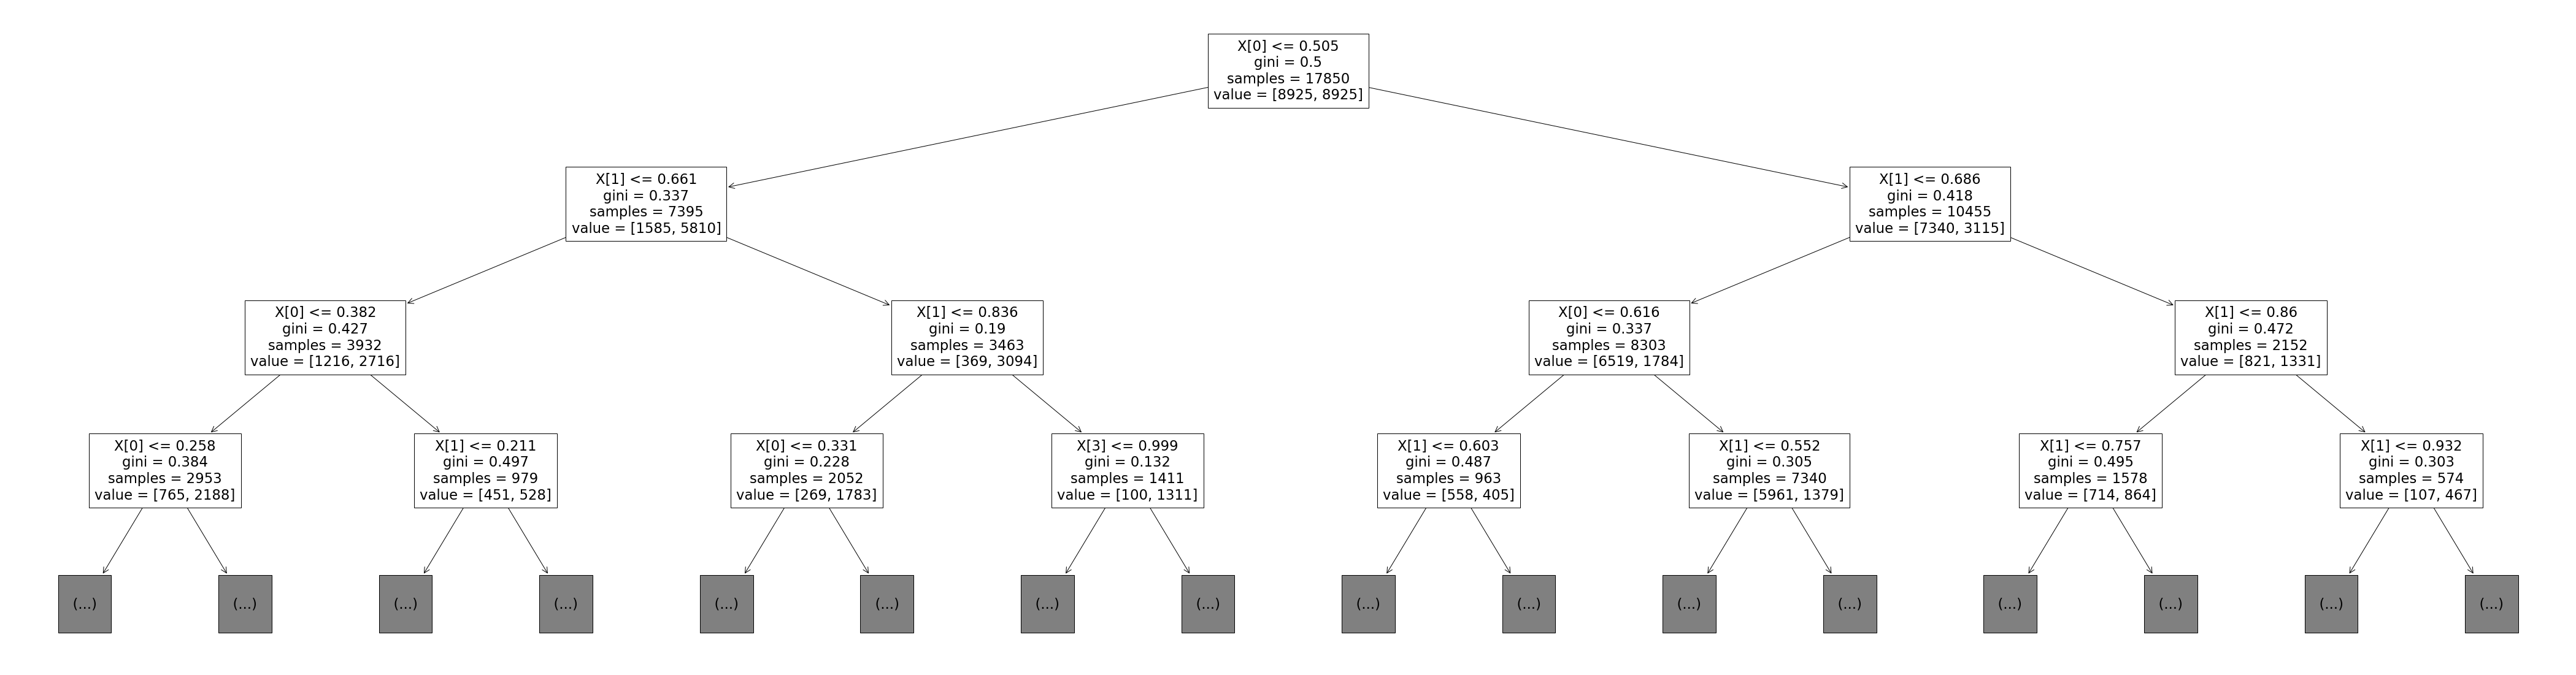

In [90]:
model = DecisionTreeClassifier()
model.fit(X_resampled, y_resampled)

fig = plt.figure(figsize=(75, 20))
plot_tree(model, ax=fig.gca(), max_depth=3)
plt.show()

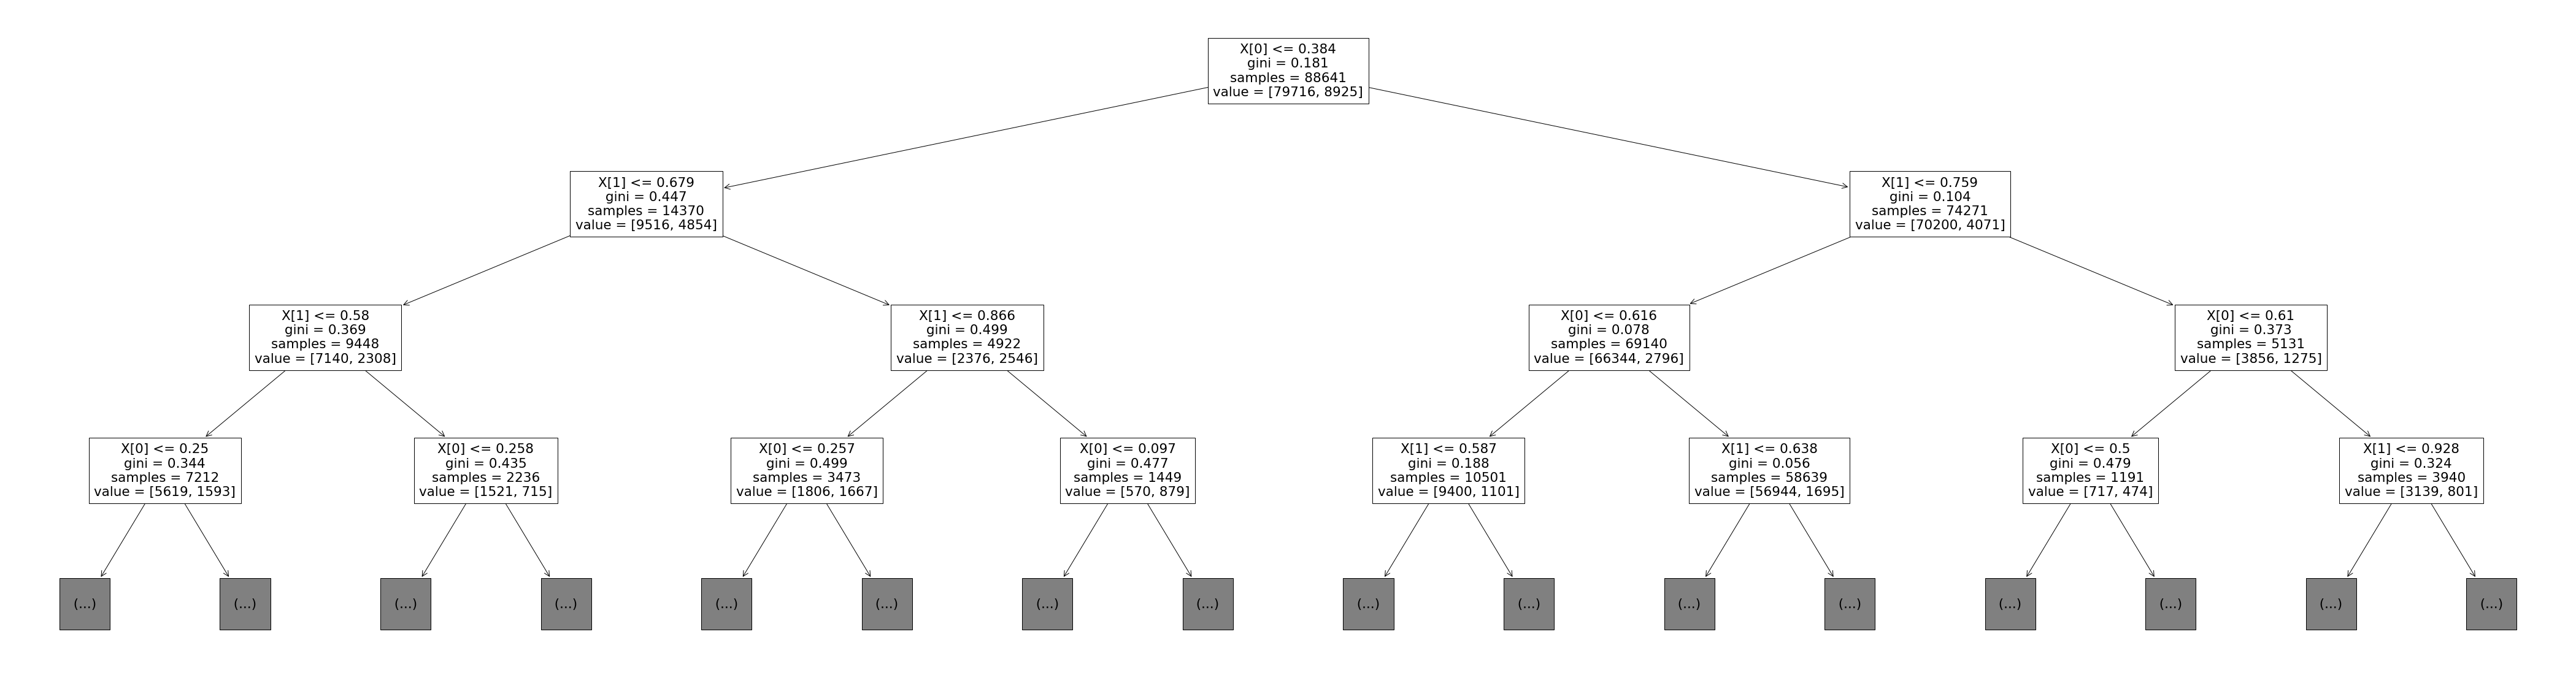

In [91]:
model = DecisionTreeClassifier()
model.fit(X, y)

fig = plt.figure(figsize=(75, 20))
plot_tree(model, ax=fig.gca(), max_depth=3)
plt.show()

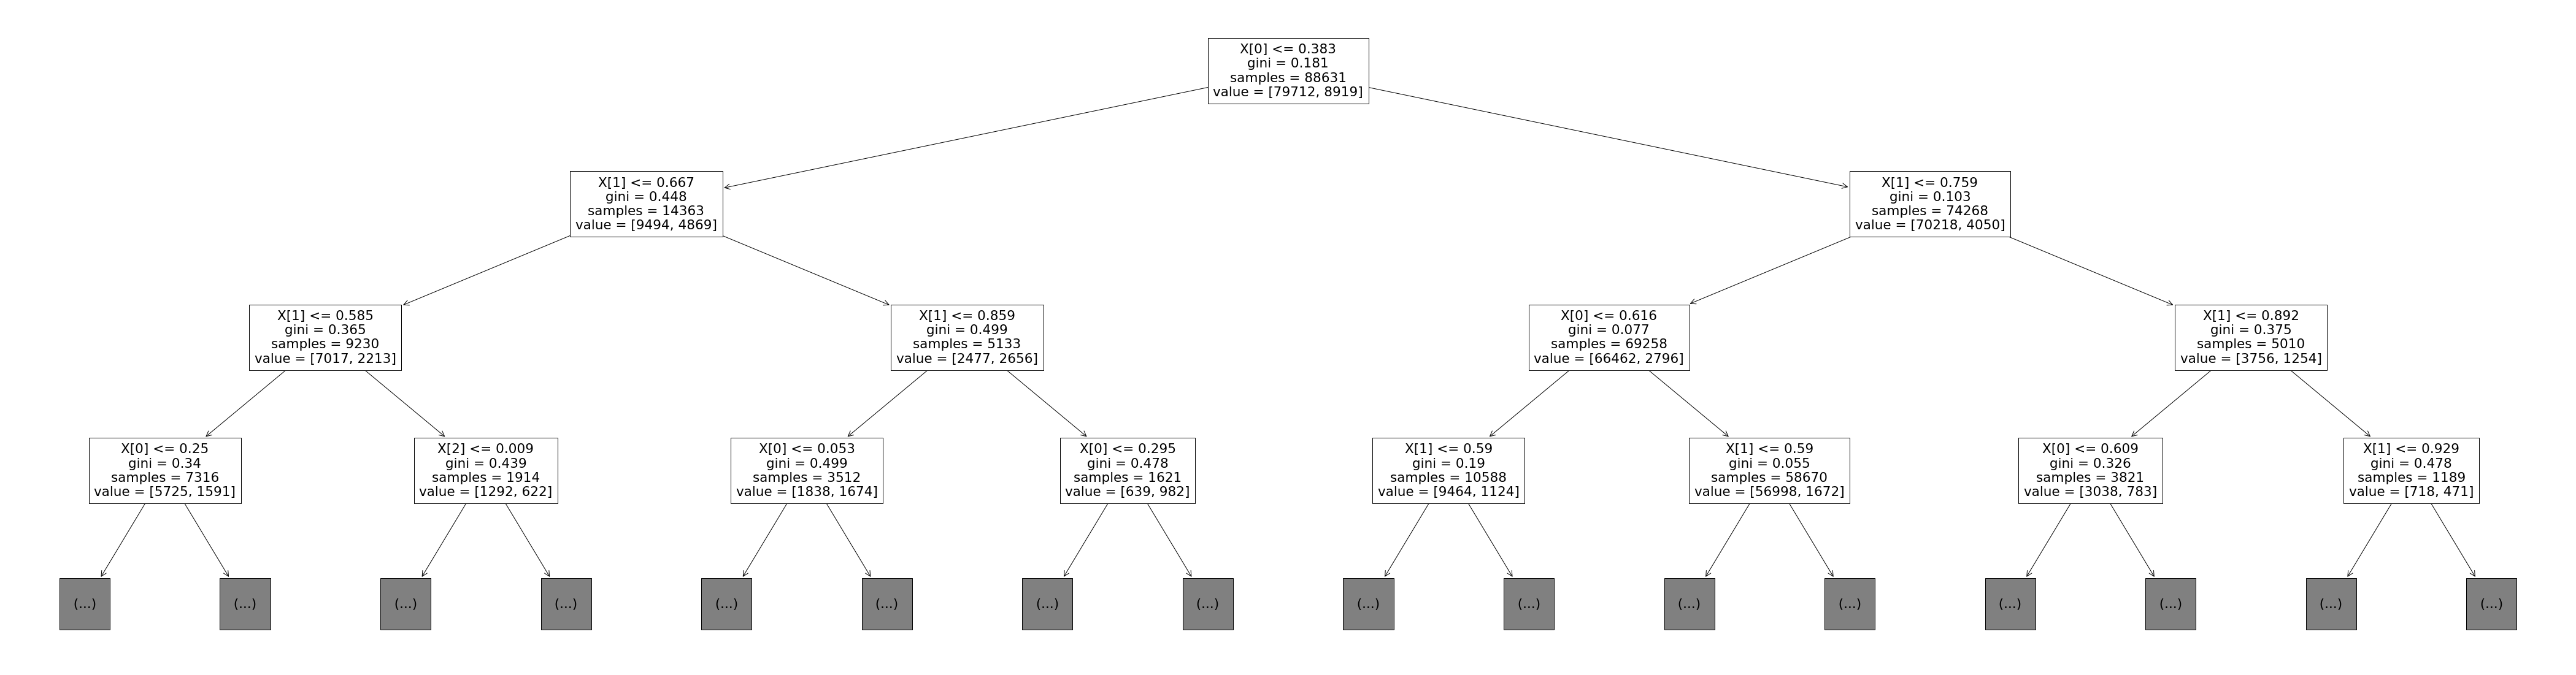

In [95]:
model = DecisionTreeClassifier()
indices_to_keep = np.random.choice(range(len(X)), len(X) - 10)
model.fit(X[indices_to_keep, :], y[indices_to_keep])

fig = plt.figure(figsize=(75, 20))
plot_tree(model, ax=fig.gca(), max_depth=3)
plt.show()